In [1]:
import numpy as np
import cv2
from read_roi import read_roi_zip
import matplotlib.pyplot as plt
from scipy.stats import kstest
import os
import rawpy
from numpy.fft import fft2,ifft2,fftshift,ifftshift,fftfreq
from scipy.stats import ks_2samp

In [2]:
def CLEAN(image,mask,gain=0.5,maxsteps=15000,limit=2,convcheck=10,variant="standard"):
    '''
    Takes an image and a binary mask, and fills in region outside the mask using the CLEAN algorithm
    
    image: input image
    mask: binary mask, 1 in region of data and 0 in background
    gain: fraction of peak to add to the clean map
    maxsteps: maximum number of cleaning loops to run
    limit: maximum acceptable standard deviation of the final remainder
    convcheck: how many loops should run before checking the convergence condition
    variant: "original" or "replace", whether or not the final product should be identical to the original in the 
        binary mask
        
    Output: cleanmap: the CLEANed image
    '''
    
    from numpy import fft
    converged=False
    nsteps=1
    maxes=[] #initialize list of maximums
    origimg=image #save for later
    
    #rescale image to odd: extra pixel in even is unaccounted for.
    (width,height)=mask.shape
        
    cleanmap=np.zeros(mask.shape,dtype=np.csingle) #initialize clean map
    
    residual=fftshift(fft2(image)) #set residual as FFT
    mask_fft=fftshift(fft2(mask)) #set mask as FFT of original 
    
    xwl=fftshift(fftfreq(width)) #get frequencies at each axis
    ywl=fftshift(fftfreq(height))
    
    W0=np.max(mask_fft) #central value of the mask is always the maximum 

    while not converged and nsteps<maxsteps:
        maxes.append(np.max(np.abs(residual)))
        coord=np.where(np.abs(residual)==np.max(np.abs(residual))) #coordinates of the maximum value of the residual
        coord=np.array([coord[0][0],coord[1][0]]) #take the first one WLOG
        
        coord2=np.array([(2*coord[0]-int(width/2))%width,(2*coord[1]-int(height/2))%height]) #compute the second coordinate in the convolution due to symmetry, python wraps around
        
        xfq=xwl[coord[0]];yfq=ywl[coord[1]] #compute frequency for finding of singular points
        if ((xfq==-0.5)|(xfq==0))&((yfq==-0.5)|(yfq==0)): #if maximum is a singular point
            a = gain*residual[coord[0],coord[1]]/W0
            mask_roll=np.roll(mask_fft,(coord[0]-int(width/2)),axis=0) #roll the matrix along the 0th axis
            mask_roll=np.roll(mask_roll,(coord[1]-int(height/2)),axis=1) #then the first
            residual=residual-(a*mask_roll)
            cleanmap[coord[0],coord[1]]=cleanmap[coord[0],coord[1]]+(a*width*height) #compute the spike and add back in. size is used here to simplify
        else: #residual max is in another location
            a=residual[coord[0],coord[1]] #value of residual spike
            W2=mask_fft[coord2[0],coord2[1]] #mask values at second coordinate
            impulse=gain*height*width*(a*W0-np.conj(a)*W2)/(W0**2-W2*np.conj(W2)) #compute impulse from backcorrected convolution
            #print("computed impulse:",impulse)
            
            mask_up=np.roll(mask_fft,(coord[0]-int(width/2)),axis=0) #roll the matrix along the 0th axis
            mask_up=np.roll(mask_up,(coord[1]-int(height/2)),axis=1) #then the first

            mask_down=np.roll(mask_fft,-(coord[0]-int(width/2)),axis=0) #then back down. This produces mirrored values for 
            mask_down=np.roll(mask_down,-(coord[1]-int(height/2)),axis=1) #the subtraction
            correction=(impulse*mask_up+np.conj(impulse)*mask_down)/(width*height) #this is the corrected matrix
            
            residual=residual-correction #correct residual
            
            negcoord=np.array([(2*int(width/2)-coord[0])%width,(2*int(height/2)-coord[1])%height]) #find coordinates at opposite points
            
            cleanmap[coord[0],coord[1]]=cleanmap[coord[0],coord[1]]+impulse #add component to clean map
            cleanmap[negcoord[0],negcoord[1]]=cleanmap[negcoord[0],negcoord[1]]+np.conj(impulse) #add conj component to clean map
        if nsteps%10==0:print("NSteps:",nsteps,end='\r')
        if nsteps%convcheck==0: #check for convergence every convcheck cycles
            if (np.max(np.abs(residual))-np.mean(np.abs(residual)))/np.std(np.abs(residual))<=limit: #if the std is small compared to the mean, assume dropoff has slowed to the point of stopping
                converged=True
                print("CONVERGED, NSTEPS:",nsteps)
            else: maxes=[] #reset if false
        nsteps+=1
    if variant=="replace":
        def imgSSE(x,*args):
            return(np.sum(np.abs(args[0]*x[0]+x[1]-args[1])))

        cleanimg=np.real(ifft2(ifftshift(cleanmap)))
        coord=np.where(mask!=0)
        cleanlist=cleanimg[coord]
        origlist=origimg[coord]
        from scipy.optimize import minimize
        a,b=minimize(imgSSE,(1,0),args=(cleanlist,origlist)).x
        cleanimg=a*cleanimg+b
        cleanimg=np.where(mask!=0,origimg,cleanimg)
        cleanmap=fftshift(fft2(cleanimg))
    
    if nsteps==maxsteps:
        print("FINISHED WITHOUT CONVERGING")
    return(np.real(ifft2(ifftshift(cleanmap))))

In [3]:
def powerSpectrum(image,nbins):
    '''
    Computes the power spectrum of an input image. Bins are logarithmically spaced. 
    
    Inputs:
        image: input image for analysis
        nbins: number of exponential bins for the spectrum to be simplified to
        
    Outputs: (Pkj, kaj)
        Pkj: power spectrum data
        kaj: average wavenumber of each bin. 
    
    '''
    width,height=image.shape
    delta=fft2(image)
    N2=width*height
    
    k1x=fftfreq(width)*2.0*np.pi
    k1y=fftfreq(height)*2.0*np.pi
    kx, ky = np.meshgrid(k1x, k1y)
    k = np.sqrt(kx**2 + ky**2)
    k[0,0]=2*np.pi
    
    lk = np.log10(k)
    Pkj,  lkj = np.histogram(lk, bins=nbins, weights=np.square(np.absolute(delta)), density=False) 
    lkaj, lkj = np.histogram(lk, bins=nbins, weights=lk, density=False) 
    nj , lkj  = np.histogram(lk, bins=nbins, density=False) 
    # P(k) and its rms Poisson error due to finite number of modes
    
    #b=-1;test=np.real(ifft2(np.where((lk>=lkj[b]),delta,0)));plt.imshow(test);plt.show() #show this band's ifft. use to determine if the band is useful
    #print(np.max(test))
    
    Pkj = Pkj / nj / N2
    lkaj = lkaj / nj 
    kaj = 10.**lkaj
    return(Pkj,kaj)

In [4]:
def physPower(image,mask,mode="STD"):
    '''
    Compute the physical (non-Fourier) power spectrum of the image for a given mask, 
    in the method of the MICA toolbox. Bins are logarithmically spaced. 
    
    Inputs: 
        image: input image for analysis
        mask: binary mask specifying the region for analysis. 
        mode: way of computing the power of each band. Options are 'STD' and 'SQR', 
            which take the standard deviation and the sum of squares respectively
            
    Output: physical power spectrum of the image
        
    '''
    width,height=image.shape
    delta=fft2(image)
    mask=mask*np.mean(image[np.where(mask!=0)])/np.max(mask)
    mfft=fft2(mask)
    N2=width*height
    
    output=[]
    
    k1x=width*fftfreq(width)*2.0*np.pi
    k1y=height*fftfreq(height)*2.0*np.pi
    kx, ky = np.meshgrid(k1x, k1y)
    k = np.sqrt(kx**2 + ky**2)
    k[0,0]=2*np.pi
    
    n=int(2*(np.log2(k[int(width/2),int(height/2)])-1))
    
    lkj=np.logspace(2,(n+2),num=(n+1),base=np.sqrt(2))
    
    for ind in range(n):
        map1=np.where(((k>=lkj[ind])&(k<lkj[ind+1])),delta,0)
        map2=np.where(((k>=lkj[ind])&(k<lkj[ind+1])),mfft,0)
        if mode=="STD": output.append(np.std(np.real(ifft2(map1)-ifft2(map2))))
        if mode=="SQR": output.append(np.sum(np.square(np.real(ifft2(map1)-ifft2(map2))))/N2)
    return(np.array(output))

In [5]:
def unifBack(img,mask,variant):
    '''
    Fills the background (non-data) region of the image with a uniform value
    
    Inputs:
        img: input image
        mask: binary mask, with 1 in data and 0 in non-data regions
        variant: 'mean' or 'black', which fill the background with the mean of the data and 0, respectively
    '''
    if variant=="mean":
        fill=np.mean(img[np.where(mask!=0)])
    elif variant=="black":
        fill=0
    output=fill*np.ones((img.shape))
    output[np.where(mask!=0)]=img[np.where(mask!=0)]
    return(output)   

In [6]:
def randBack(img,mask):
    '''
    Fills the non-data region with random selections from the data region, with Gaussian smoothing.  
    
    Inputs: 
        img: The image to be modified
        mask: The binary mask, where 1 is data and 0 is non-data. 
    '''
    coord=np.where(mask!=0)
    data=img[coord]

    emptcoord=np.where(mask==0)
    output=np.zeros((img.shape))
    length=output[emptcoord].size
    output[emptcoord]=data[np.random.choice(len(data),length,replace=True)]
    import scipy.ndimage as ndimage
    output=ndimage.gaussian_filter(output, sigma=(1, 1), order=0)
    output[coord]=data
    return(output)

In [7]:
def rectArea(img):
    #cuts out a random square region of an input image, setting all other data to 0
    x,y=np.random.randint(0,43,size=2)
    mask=np.zeros(img.shape)
    mask[x:(x+85),y:(y+85)]=1
    return(np.multiply(img,mask))

In [9]:
def chi2(E,x): #computes the chi2 difference between the inputs
    return(np.sum(np.square(x-E)/E))

In [10]:
def sumdiff(x,y): #computes the sum of the differences
    return(np.sum(np.abs(x-y)))

In [11]:
def SSE(x,y): #computes the sum of the squared errors
    return(np.sum(np.square(x-y)))

In [12]:
def Processor(args,version="KS",el=-1):
    '''
    Processes and computes the matching percentages for each different comparison method.
    
    Inputs: 
        args: a tuple of lists of images to compare, with the first being the original.
        version: comparison method, can be physical power spectra ('STD' or 'SQR') or 
        power spectra (chi2','SAD','SSE')
        el: the last point in the spectrum. set to None if you want all of them, usually set to -1, 
            since the last band tests to have non-visible data
    '''
    import string
    names=np.array(list(string.ascii_lowercase)[0:len(args)-1])
    rank=np.zeros((len(args[0]),len(args)-1),dtype=str)
    means=np.zeros(len(args[0]));stds=np.zeros(len(args[0]))
    
    for index in range(len(args[0])):
        if index%10==0: print("Processing:",index,"/",len(args[0]),end='\r')
        oimg=args[0][index]
        if (version=="STD")or(version=="SQR"):
            ospec=physPower(oimg,np.ones(oimg.shape),version)
        else:
            opkj,kaj=powerSpectrum(oimg,10)
            opkj=opkj[0:el];kaj=kaj[0:el]               
            opkj=np.log(opkj) #computes with the logarithm
            
        chiarr=np.zeros(len(args)-1)
        for imgind in range(len(args)-1):
            image=args[imgind+1][index]
            if (version=="STD")or(version=="SQR"):
                mask=np.where(image!=0,1,0)
                tspec=physPower(image,mask,version)
                chiarr[imgind]=sumdiff(ospec/np.sum(ospec),tspec/np.sum(tspec))
            else:
                tpkj,kaj=powerSpectrum(image,10)
                tpkj=tpkj[0:el];kaj=kaj[0:el]               
                tpkj=np.log(tpkj) #computes with the logarithm
                if version=="KS":
                    chiarr[imgind]=1-ks_2samp(opkj,tpkj).pvalue
                if version=="chi2":
                    chiarr[imgind]=chi2(opkj,tpkj)
                if version=="SAD":
                    chiarr[imgind]=sumdiff(opkj,tpkj)
                if version=="SSE":
                    chiarr[imgind]=SSE(opkj,tpkj)

        rank[index,:]=names[np.argsort(chiarr)]
        means[index]=np.mean(chiarr);stds[index]=np.std(chiarr)
        
    final=np.zeros(len(args)-1)
    for i in range(len(names)):
        final[i]=100*np.sum(rank[:,0]==names[i])/len(args[0])
    return(final,np.median(means),np.median(stds))

In [83]:
#THIS GENERATES THE OCTOPUS SUB-IMAGES
path=os.getcwd()+"\Data\\"
filelist=os.listdir(path)

subpath=os.getcwd()+"\Sub-Data\\"

for name in filelist: 
    name=name.split(".")
    if name[-1]=="zip": continue
    name=name[0]

    image=rawpy.imread(path+name+".CR2")
    image=image.postprocess() #Loads in the data for analysis
    image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    roiset=read_roi_zip(path+name+".zip")
    ind=0
    for roi in roiset:
        roi=roiset[roi]
        left,top=roi['left'],roi['top']
        width,height=roi['width'],roi['height']
        subimg=image[top:(top+height),left:(left+width)]
        
        cv2.imwrite((subpath+name+"_"+str(ind)+".tiff"),subimg)
        ind+=1

KeyboardInterrupt: 

In [13]:
#READS IN ROIS 
rois=read_roi_zip(os.getcwd()+"\\RoiSet.zip")
roiarr=np.empty((15,),dtype=object)
i=0
for ind in rois:
    roi=rois[ind]
    pts=np.array([roi['x'],roi['y']],dtype=np.int32).T
    mask=np.zeros((128,128))
    cv2.fillPoly(mask,[pts],1)
    roiarr[i]=mask
    i+=1

1434
CONVERGED, NSTEPS: 2690
CONVERGED, NSTEPS: 2690


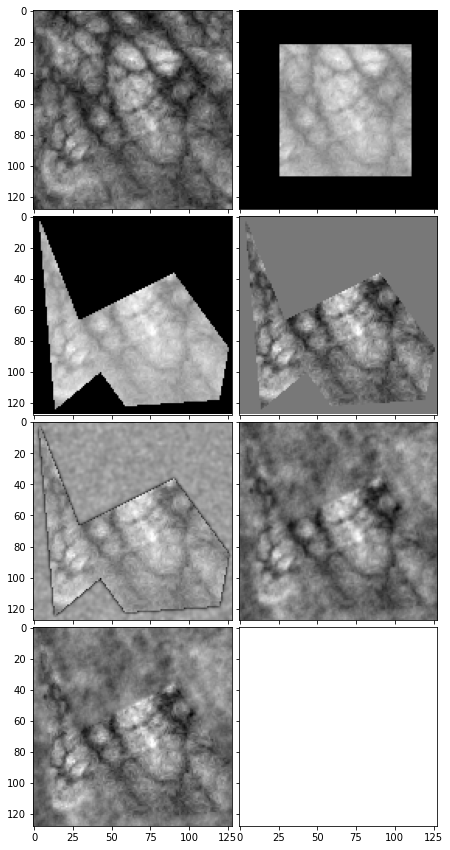

In [24]:
# Visual Test
subpath=os.getcwd()+"\Sub-Data\\" #set path of subimages
filelist=os.listdir(subpath) #list subimages
print(len(filelist))
name=filelist[np.random.randint(0,len(filelist))] #grab random file
mask=roiarr[np.random.randint(0,15)] #grab random mask

image=cv2.imread(subpath+name)
image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

from mpl_toolkits.axes_grid1 import ImageGrid

fig=plt.figure(figsize=(15,15))

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
axmat=[]
for ax in grid:
    axmat.append(ax)
axmat[0].imshow(image,cmap='gray')

test=rectArea(image)
axmat[1].imshow(test,cmap='gray')

test=unifBack(image,mask,"black")
axmat[2].imshow(test,cmap='gray')

test=unifBack(image,mask,"mean")
axmat[3].imshow(test,cmap='gray')

test=randBack(image,mask)
axmat[4].imshow(test,cmap='gray')

cimg=np.multiply(image,mask)
test=CLEAN(cimg,mask,variant="standard")
axmat[5].imshow(test,cmap='gray')

test=CLEAN(cimg,mask,variant="replace")
axmat[6].imshow(test,cmap='gray');plt.show()

In [16]:
#Create lists of processed images WARNING: SLOW
subpath=os.getcwd()+"\Sub-Data\\" #set path of subimages
filelist=os.listdir(subpath) #list subimages
filelist=filelist[0,]

normimg=np.zeros((len(filelist)),dtype=object)
rectimg=np.zeros((len(filelist)),dtype=object) #initialize set for rectangle mask
polyimgb=np.zeros((len(filelist)),dtype=object)
polyimgm=np.zeros((len(filelist)),dtype=object)
randimg=np.zeros((len(filelist)),dtype=object)
cleanorig=np.zeros((len(filelist)),dtype=object)
cleanrep=np.zeros((len(filelist)),dtype=object)

index=0

for name in filelist:
    #read in and grayscale subimages
    image=cv2.imread(subpath+name)
    image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #get and process image
    mask=roiarr[np.random.randint(0,15)] #grab random mask
    
    normimg[index]=image
    
    rectimg[index]=rectArea(image)
    
    polyimgb[index]=unifBack(image,mask,"black")
    
    polyimgm[index]=unifBack(image,mask,"mean")
    
    randimg[index]=randBack(image,mask)
    
    cleanorig[index]=CLEAN(np.multiply(image,mask),mask,variant="standard")
    
    cleanrep[index]=CLEAN(np.multiply(image,mask),mask,variant="replace")
    
    index+=1
    

CONVERGED, NSTEPS: 30700 2900
CONVERGED, NSTEPS: 30702210
CONVERGED, NSTEPS: 3020
CONVERGED, NSTEPS: 30206002690 2990
CONVERGED, NSTEPS: 29704026202720
CONVERGED, NSTEPS: 29701310196022602870 2970
CONVERGED, NSTEPS: 254030
CONVERGED, NSTEPS: 2540
CONVERGED, NSTEPS: 2390760
CONVERGED, NSTEPS: 2390
CONVERGED, NSTEPS: 2870
CONVERGED, NSTEPS: 2870
CONVERGED, NSTEPS: 2220
CONVERGED, NSTEPS: 222014602150
CONVERGED, NSTEPS: 2730243025302630
CONVERGED, NSTEPS: 27302021402670
CONVERGED, NSTEPS: 271024602570
CONVERGED, NSTEPS: 271017601850
CONVERGED, NSTEPS: 2920
CONVERGED, NSTEPS: 2920730
CONVERGED, NSTEPS: 315060132018202970
CONVERGED, NSTEPS: 3150100
CONVERGED, NSTEPS: 2940
CONVERGED, NSTEPS: 2940
CONVERGED, NSTEPS: 3140
CONVERGED, NSTEPS: 3140
CONVERGED, NSTEPS: 3040
CONVERGED, NSTEPS: 30400
CONVERGED, NSTEPS: 289020 1140
CONVERGED, NSTEPS: 289001490 16801900 2010 2440 2540
CONVERGED, NSTEPS: 263002440
CONVERGED, NSTEPS: 2630020802170
CONVERGED, NSTEPS: 25900 24802570
CONVERGED, NSTEPS: 2590

CONVERGED, NSTEPS: 2650001850
CONVERGED, NSTEPS: 2640
CONVERGED, NSTEPS: 2640
CONVERGED, NSTEPS: 2710
CONVERGED, NSTEPS: 2710
CONVERGED, NSTEPS: 2480
CONVERGED, NSTEPS: 2480
CONVERGED, NSTEPS: 2450
CONVERGED, NSTEPS: 2450
CONVERGED, NSTEPS: 27200
CONVERGED, NSTEPS: 2720
CONVERGED, NSTEPS: 2650
CONVERGED, NSTEPS: 2650
CONVERGED, NSTEPS: 2590
CONVERGED, NSTEPS: 2590
CONVERGED, NSTEPS: 2420
CONVERGED, NSTEPS: 2420
CONVERGED, NSTEPS: 2540
CONVERGED, NSTEPS: 2540
CONVERGED, NSTEPS: 2730
CONVERGED, NSTEPS: 2730
CONVERGED, NSTEPS: 2500
CONVERGED, NSTEPS: 2500
CONVERGED, NSTEPS: 2780
CONVERGED, NSTEPS: 2780
CONVERGED, NSTEPS: 2820
CONVERGED, NSTEPS: 2820
CONVERGED, NSTEPS: 2280
CONVERGED, NSTEPS: 2280
CONVERGED, NSTEPS: 2460
CONVERGED, NSTEPS: 2460
CONVERGED, NSTEPS: 245001300
CONVERGED, NSTEPS: 2450
CONVERGED, NSTEPS: 2500
CONVERGED, NSTEPS: 2500
CONVERGED, NSTEPS: 2610
CONVERGED, NSTEPS: 2610
CONVERGED, NSTEPS: 2340
CONVERGED, NSTEPS: 2340201870
CONVERGED, NSTEPS: 2800
CONVERGED, NSTEPS: 280

CONVERGED, NSTEPS: 2500
CONVERGED, NSTEPS: 2310
CONVERGED, NSTEPS: 2310
CONVERGED, NSTEPS: 21600
CONVERGED, NSTEPS: 2160
CONVERGED, NSTEPS: 2430
CONVERGED, NSTEPS: 2430
CONVERGED, NSTEPS: 2370
CONVERGED, NSTEPS: 2370
CONVERGED, NSTEPS: 2360
CONVERGED, NSTEPS: 2360
CONVERGED, NSTEPS: 1980
CONVERGED, NSTEPS: 1980
CONVERGED, NSTEPS: 2290
CONVERGED, NSTEPS: 2290
CONVERGED, NSTEPS: 2350
CONVERGED, NSTEPS: 2350
CONVERGED, NSTEPS: 2190
CONVERGED, NSTEPS: 2190
CONVERGED, NSTEPS: 2620
CONVERGED, NSTEPS: 2620
CONVERGED, NSTEPS: 2550
CONVERGED, NSTEPS: 25500
CONVERGED, NSTEPS: 2410
CONVERGED, NSTEPS: 2410
CONVERGED, NSTEPS: 1960
CONVERGED, NSTEPS: 1960
CONVERGED, NSTEPS: 2460
CONVERGED, NSTEPS: 2460
CONVERGED, NSTEPS: 2410
CONVERGED, NSTEPS: 2410160
CONVERGED, NSTEPS: 2410
CONVERGED, NSTEPS: 2410
CONVERGED, NSTEPS: 2140
CONVERGED, NSTEPS: 2140
CONVERGED, NSTEPS: 2420
CONVERGED, NSTEPS: 2420
CONVERGED, NSTEPS: 2160
CONVERGED, NSTEPS: 2160
CONVERGED, NSTEPS: 2000
CONVERGED, NSTEPS: 2000
CONVERGED, 

CONVERGED, NSTEPS: 3050
CONVERGED, NSTEPS: 3050
CONVERGED, NSTEPS: 2700560
CONVERGED, NSTEPS: 2700023502380
CONVERGED, NSTEPS: 31001610
CONVERGED, NSTEPS: 3100
CONVERGED, NSTEPS: 2970
CONVERGED, NSTEPS: 2970
CONVERGED, NSTEPS: 2470
CONVERGED, NSTEPS: 2470
CONVERGED, NSTEPS: 2650
CONVERGED, NSTEPS: 2650
CONVERGED, NSTEPS: 2540
CONVERGED, NSTEPS: 2540
CONVERGED, NSTEPS: 2380
CONVERGED, NSTEPS: 2380
CONVERGED, NSTEPS: 2760
CONVERGED, NSTEPS: 27600
CONVERGED, NSTEPS: 2430
CONVERGED, NSTEPS: 2430
CONVERGED, NSTEPS: 2340
CONVERGED, NSTEPS: 2340
CONVERGED, NSTEPS: 2870
CONVERGED, NSTEPS: 2870
CONVERGED, NSTEPS: 2750
CONVERGED, NSTEPS: 2750
CONVERGED, NSTEPS: 2650
CONVERGED, NSTEPS: 2650
CONVERGED, NSTEPS: 3060
CONVERGED, NSTEPS: 3060
CONVERGED, NSTEPS: 3000
CONVERGED, NSTEPS: 3000980
CONVERGED, NSTEPS: 2720
CONVERGED, NSTEPS: 2720
CONVERGED, NSTEPS: 2850
CONVERGED, NSTEPS: 2850
CONVERGED, NSTEPS: 3070
CONVERGED, NSTEPS: 3070
CONVERGED, NSTEPS: 2850
CONVERGED, NSTEPS: 2850
CONVERGED, NSTEPS: 3

CONVERGED, NSTEPS: 3020
CONVERGED, NSTEPS: 3020
CONVERGED, NSTEPS: 2830
CONVERGED, NSTEPS: 28300
CONVERGED, NSTEPS: 2950
CONVERGED, NSTEPS: 2950
CONVERGED, NSTEPS: 3100
CONVERGED, NSTEPS: 3100
CONVERGED, NSTEPS: 2890
CONVERGED, NSTEPS: 2890
CONVERGED, NSTEPS: 3160
CONVERGED, NSTEPS: 3160
CONVERGED, NSTEPS: 2630
CONVERGED, NSTEPS: 2630
CONVERGED, NSTEPS: 2780
CONVERGED, NSTEPS: 2780
CONVERGED, NSTEPS: 2820
CONVERGED, NSTEPS: 2820
CONVERGED, NSTEPS: 2640
CONVERGED, NSTEPS: 2640
CONVERGED, NSTEPS: 2810
CONVERGED, NSTEPS: 2810
CONVERGED, NSTEPS: 2920
CONVERGED, NSTEPS: 2920
CONVERGED, NSTEPS: 2520
CONVERGED, NSTEPS: 2520
CONVERGED, NSTEPS: 2700
CONVERGED, NSTEPS: 2700
CONVERGED, NSTEPS: 2640
CONVERGED, NSTEPS: 2640
CONVERGED, NSTEPS: 2560
CONVERGED, NSTEPS: 2560
CONVERGED, NSTEPS: 2730
CONVERGED, NSTEPS: 2730
CONVERGED, NSTEPS: 2810
CONVERGED, NSTEPS: 2810
CONVERGED, NSTEPS: 2630
CONVERGED, NSTEPS: 2630
CONVERGED, NSTEPS: 2840
CONVERGED, NSTEPS: 2840
CONVERGED, NSTEPS: 2620
CONVERGED, NSTE

In [42]:
args=(normimg,rectimg,polyimgb,polyimgm,randimg,cleanorig,cleanrep)
#actually computes the data
args=(normimg,rectimg,polyimgb,polyimgm,randimg,cleanorig,cleanrep)
print("chi2:",Processor(args,'chi2'))
print("SAD:",Processor(args,'SAD'))
print("SSE:",Processor(args,'SSE'))
print("STD:",Processor(args,'STD'))
print("SQR:",Processor(args,'SQR'))

(array([36.33193863, 18.68898187, 13.11018131,  0.20920502,  1.46443515,
       30.19525802]), 0.17651444513395315, 0.05002944656544643)
